# Load Data and Print Class Distribution

In [1]:
import os
from torchvision import datasets, transforms
from collections import Counter

# Paths to your dataset on Kaggle
# Ensure these paths match your Kaggle input directory structure
train_dir = "/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/train"
val_dir = "/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/test" # Often named 'test' in Kaggle datasets, used as validation here

# Basic transform for counting
basic_transform = transforms.Compose([
    transforms.ToTensor()
])

# Load datasets to get class names and counts
train_dataset_info = datasets.ImageFolder(root=train_dir, transform=basic_transform)
val_dataset_info = datasets.ImageFolder(root=val_dir, transform=basic_transform)

# Get class names
class_names = train_dataset_info.classes
num_classes = len(class_names)
print(f"Class Names: {class_names}")
print(f"Number of Classes: {num_classes}")

# Function to count images per class
def count_images_per_class(dataset, dataset_name):
    class_counts = Counter()
    # dataset.samples is a list of (filepath, class_index)
    for _, label_idx in dataset.samples:
        class_name = dataset.classes[label_idx]
        class_counts[class_name] += 1

    print(f"\n{dataset_name} dataset class distribution:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images")

# Print counts
count_images_per_class(train_dataset_info, "Train")
count_images_per_class(val_dataset_info, "Validation")

Class Names: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
Number of Classes: 4

Train dataset class distribution:
Mild Impairment: 2560 images
Moderate Impairment: 2560 images
No Impairment: 2560 images
Very Mild Impairment: 2560 images

Validation dataset class distribution:
Mild Impairment: 179 images
Moderate Impairment: 12 images
No Impairment: 640 images
Very Mild Impairment: 448 images


# Image Preprocessing and Conversion to NumPy Arrays

In [2]:
import numpy as np
import torch
from torchvision import datasets, transforms
from tqdm import tqdm

# Image preprocessing transforms
image_size = (128, 128)  # Standardize image size
mean = [0.485, 0.456, 0.406] # Standard ImageNet mean
std  = [0.229, 0.224, 0.225] # Standard ImageNet std

preprocess_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load datasets with preprocessing
train_dataset_processed = datasets.ImageFolder(root=train_dir, transform=preprocess_transform)
val_dataset_processed = datasets.ImageFolder(root=val_dir, transform=preprocess_transform)

# Function to convert dataset to NumPy arrays
def dataset_to_numpy(dataset, dataset_name):
    X = []
    y = []
    print(f"Converting {dataset_name} dataset to NumPy arrays...")
    for img, label in tqdm(dataset, desc=f"Processing {dataset_name}"):
        X.append(img.numpy()) # Convert tensor to numpy
        y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

# Convert to NumPy arrays
X_train, y_train = dataset_to_numpy(train_dataset_processed, "Train")
X_val, y_val = dataset_to_numpy(val_dataset_processed, "Validation")

# Define directory to save NumPy arrays
save_dir = "/kaggle/working/numpy_arrays"
os.makedirs(save_dir, exist_ok=True)

# Save arrays
np.save(os.path.join(save_dir, 'X_train.npy'), X_train)
np.save(os.path.join(save_dir, 'y_train.npy'), y_train)
np.save(os.path.join(save_dir, 'X_val.npy'), X_val)
np.save(os.path.join(save_dir, 'y_val.npy'), y_val)

print(f"\n✅ Saved all arrays to: {save_dir}")

# Check shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_val shape:   {y_val.shape}")
print(f"Class names from ImageFolder: {train_dataset_processed.classes}") # Should match class_names from cell 1
# Update class_names based on the actual loaded dataset structure if necessary
class_names = train_dataset_processed.classes
num_classes = len(class_names)
print(f"Updated Class Names: {class_names}")
print(f"Updated Number of Classes: {num_classes}")

Converting Train dataset to NumPy arrays...


Processing Train: 100%|██████████| 10240/10240 [00:34<00:00, 298.10it/s]


Converting Validation dataset to NumPy arrays...


Processing Validation: 100%|██████████| 1279/1279 [00:04<00:00, 304.51it/s]



✅ Saved all arrays to: /kaggle/working/numpy_arrays
X_train shape: (10240, 3, 128, 128)
y_train shape: (10240,)
X_val shape:   (1279, 3, 128, 128)
y_val shape:   (1279,)
Class names from ImageFolder: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
Updated Class Names: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
Updated Number of Classes: 4


# Create PyTorch Datasets and DataLoaders

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class NumpyImageDataset(Dataset):
    def __init__(self, images, labels):
        # Convert numpy arrays to torch tensors
        self.images = torch.tensor(images, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Load numpy arrays (if not already in memory or if kernel restarted)
# X_train = np.load("/kaggle/working/numpy_arrays/X_train.npy")
# y_train = np.load("/kaggle/working/numpy_arrays/y_train.npy")
# X_val = np.load("/kaggle/working/numpy_arrays/X_val.npy")
# y_val = np.load("/kaggle/working/numpy_arrays/y_val.npy")

# Create datasets
train_dataset = NumpyImageDataset(X_train, y_train)
val_dataset = NumpyImageDataset(X_val, y_val)

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("✅ DataLoaders created.")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

✅ DataLoaders created.
Number of training batches: 320
Number of validation batches: 40


# Define the CNN Model (AlzheimerCNN)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class AlzheimerCNN(nn.Module):
    def __init__(self, num_classes_model): # Renamed argument for clarity
        super(AlzheimerCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # Input: (B, 3, 128, 128) -> Output: (B, 32, 128, 128)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),      # Output: (B, 32, 64, 64)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Output: (B, 64, 64, 64)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),      # Output: (B, 64, 32, 32)

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Output: (B, 128, 32, 32)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),      # Output: (B, 128, 16, 16)
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # Added another conv layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)       # Output: (B, 256, 8, 8)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512), # Adjusted for new conv layer output
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes_model) # num_classes_model passed during instantiation
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# num_classes was defined in Cell 1 and Cell 2 based on dataset
model = AlzheimerCNN(num_classes_model=num_classes).to(device) 
print(f"✅ AlzheimerCNN model initialized and moved to {device}.")
print(f"Number of classes for the model: {num_classes}")

# Optional: Print model summary (requires torchsummary)
# from torchsummary import summary
# summary(model, input_size=(3, 128, 128))

✅ AlzheimerCNN model initialized and moved to cuda.
Number of classes for the model: 4


# Training and Evaluation Functions

In [5]:
import torch.optim as optim
from tqdm import tqdm # Ensure tqdm is imported if not already

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model_train, dataloader, criterion_train, optimizer_train, device_train):
    model_train.train() # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device_train), labels.to(device_train)

        optimizer_train.zero_grad()  # Zero the parameter gradients
        outputs = model_train(inputs) # Forward pass
        loss = criterion_train(outputs, labels) # Compute loss
        loss.backward() # Backward pass
        optimizer_train.step() # Optimize

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions.double() / total_samples * 100
    return epoch_loss, epoch_acc.item()


def evaluate_model(model_eval, dataloader, criterion_eval, device_eval):
    model_eval.eval() # Set model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    all_preds_eval = []
    all_labels_eval = []
    all_probs_eval = []

    with torch.no_grad(): # Disable gradient calculation
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device_eval), labels.to(device_eval)

            outputs = model_eval(inputs)
            loss = criterion_eval(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1) # Get probabilities for ROC/PR curves
            
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
            
            all_preds_eval.extend(preds.cpu().numpy())
            all_labels_eval.extend(labels.cpu().numpy())
            all_probs_eval.extend(probs.cpu().numpy())


    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions.double() / total_samples * 100
    return epoch_loss, epoch_acc.item(), np.array(all_labels_eval), np.array(all_preds_eval), np.array(all_probs_eval)

print("✅ Training and evaluation functions defined.")

✅ Training and evaluation functions defined.


# Run Training Loop

In [6]:
epochs = 25 # Increased epochs, adjust as needed
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

print(f"Starting training for {epochs} epochs...")
for epoch in range(epochs):
    print(f"\n--- Epoch {epoch+1}/{epochs} ---")
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    val_loss, val_acc, _, _, _ = evaluate_model(model, val_loader, criterion, device) # Underscores for unused y_true, y_pred, y_prob here
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} Summary: "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

print("\n✅ Training complete.")

Starting training for 25 epochs...

--- Epoch 1/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 104.22it/s]


Epoch 1 Summary: Train Loss: 0.9714, Train Accuracy: 52.81% | Val Loss: 0.8497, Val Accuracy: 56.45%

--- Epoch 2/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 106.82it/s]


Epoch 2 Summary: Train Loss: 0.5371, Train Accuracy: 75.09% | Val Loss: 0.8286, Val Accuracy: 59.89%

--- Epoch 3/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 110.16it/s]


Epoch 3 Summary: Train Loss: 0.4123, Train Accuracy: 81.45% | Val Loss: 0.6243, Val Accuracy: 70.13%

--- Epoch 4/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 111.16it/s]


Epoch 4 Summary: Train Loss: 0.3226, Train Accuracy: 85.92% | Val Loss: 0.5239, Val Accuracy: 77.64%

--- Epoch 5/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 107.06it/s]


Epoch 5 Summary: Train Loss: 0.2574, Train Accuracy: 88.90% | Val Loss: 0.4455, Val Accuracy: 80.53%

--- Epoch 6/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 110.48it/s]


Epoch 6 Summary: Train Loss: 0.1943, Train Accuracy: 91.95% | Val Loss: 0.4038, Val Accuracy: 83.58%

--- Epoch 7/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 113.86it/s]


Epoch 7 Summary: Train Loss: 0.1519, Train Accuracy: 94.01% | Val Loss: 0.3095, Val Accuracy: 87.72%

--- Epoch 8/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 112.86it/s]


Epoch 8 Summary: Train Loss: 0.1132, Train Accuracy: 95.84% | Val Loss: 0.2796, Val Accuracy: 89.99%

--- Epoch 9/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 112.40it/s]


Epoch 9 Summary: Train Loss: 0.0999, Train Accuracy: 96.23% | Val Loss: 0.2488, Val Accuracy: 91.79%

--- Epoch 10/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 104.60it/s]


Epoch 10 Summary: Train Loss: 0.0753, Train Accuracy: 97.28% | Val Loss: 0.2451, Val Accuracy: 91.48%

--- Epoch 11/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 111.55it/s]


Epoch 11 Summary: Train Loss: 0.0617, Train Accuracy: 97.71% | Val Loss: 0.2332, Val Accuracy: 92.26%

--- Epoch 12/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 108.01it/s]


Epoch 12 Summary: Train Loss: 0.0505, Train Accuracy: 98.20% | Val Loss: 0.2494, Val Accuracy: 91.79%

--- Epoch 13/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 111.37it/s]


Epoch 13 Summary: Train Loss: 0.0592, Train Accuracy: 97.99% | Val Loss: 0.1897, Val Accuracy: 94.61%

--- Epoch 14/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 105.16it/s]


Epoch 14 Summary: Train Loss: 0.0439, Train Accuracy: 98.32% | Val Loss: 0.2063, Val Accuracy: 93.90%

--- Epoch 15/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 111.29it/s]


Epoch 15 Summary: Train Loss: 0.0391, Train Accuracy: 98.54% | Val Loss: 0.1808, Val Accuracy: 95.00%

--- Epoch 16/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 109.01it/s]


Epoch 16 Summary: Train Loss: 0.0371, Train Accuracy: 98.76% | Val Loss: 0.1963, Val Accuracy: 93.51%

--- Epoch 17/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 109.25it/s]


Epoch 17 Summary: Train Loss: 0.0455, Train Accuracy: 98.38% | Val Loss: 0.1915, Val Accuracy: 94.68%

--- Epoch 18/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 110.20it/s]


Epoch 18 Summary: Train Loss: 0.0379, Train Accuracy: 98.69% | Val Loss: 0.4848, Val Accuracy: 88.74%

--- Epoch 19/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 109.89it/s]


Epoch 19 Summary: Train Loss: 0.0443, Train Accuracy: 98.51% | Val Loss: 0.1439, Val Accuracy: 95.54%

--- Epoch 20/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 109.12it/s]


Epoch 20 Summary: Train Loss: 0.0358, Train Accuracy: 98.89% | Val Loss: 0.2100, Val Accuracy: 95.39%

--- Epoch 21/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 111.58it/s]


Epoch 21 Summary: Train Loss: 0.0273, Train Accuracy: 99.07% | Val Loss: 0.2183, Val Accuracy: 94.45%

--- Epoch 22/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 109.76it/s]


Epoch 22 Summary: Train Loss: 0.0430, Train Accuracy: 98.54% | Val Loss: 0.2107, Val Accuracy: 94.06%

--- Epoch 23/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 110.50it/s]


Epoch 23 Summary: Train Loss: 0.0205, Train Accuracy: 99.24% | Val Loss: 0.4381, Val Accuracy: 91.16%

--- Epoch 24/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 109.89it/s]


Epoch 24 Summary: Train Loss: 0.0474, Train Accuracy: 98.48% | Val Loss: 0.1869, Val Accuracy: 93.59%

--- Epoch 25/25 ---


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 111.76it/s]

Epoch 25 Summary: Train Loss: 0.0194, Train Accuracy: 99.36% | Val Loss: 0.1494, Val Accuracy: 96.79%

✅ Training complete.


# Plot Training and Validation Metrics

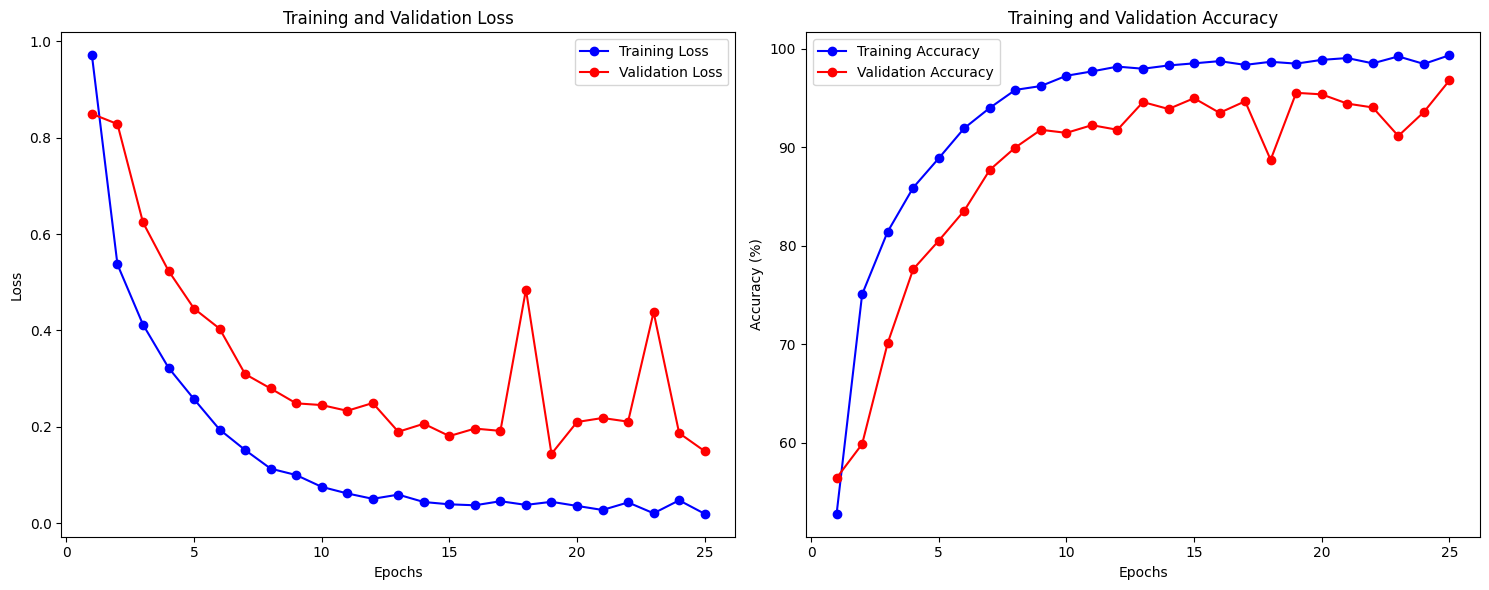

In [7]:
import matplotlib.pyplot as plt

def plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    epochs_range = range(1, len(train_loss_history) + 1)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss_history, 'bo-', label='Training Loss')
    plt.plot(epochs_range, val_loss_history, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_acc_history, 'bo-', label='Training Accuracy')
    plt.plot(epochs_range, val_acc_history, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

# Save the Trained Model

In [8]:
model_save_dir = "/kaggle/working/saved_models"
os.makedirs(model_save_dir, exist_ok=True)
model_path = os.path.join(model_save_dir, "alzheimer_cnn_model.pth")

torch.save(model.state_dict(), model_path)
print(f"✅ Model saved to: {model_path}")

# To load later:
# model_load = AlzheimerCNN(num_classes_model=num_classes) # num_classes from dataset
# model_load.load_state_dict(torch.load(model_path))
# model_load.to(device)
# model_load.eval()
# print("✅ Model loaded and ready for inference.")

✅ Model saved to: /kaggle/working/saved_models/alzheimer_cnn_model.pth


# Detailed Evaluation: Classification Report and Metrics

In [9]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, confusion_matrix

# Ensure class_names is defined correctly from your dataset (Cell 1 or 2)
# If not, redefine it based on train_dataset_info.classes or train_dataset_processed.classes
# Example: class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
# Or dynamically: class_names = train_dataset_info.classes # from cell 1

print(f"Using Class Names for Report: {class_names}")

# Get predictions from the validation set
_, _, y_true_val, y_pred_val, y_prob_val = evaluate_model(model, val_loader, criterion, device)

# Generate Classification Report
report = classification_report(
    y_true_val, y_pred_val,
    target_names=class_names,
    digits=4,  # For precision in the report
    zero_division=0 # Handles cases where a class has no predictions
)
print("\n📋 Classification Report (Validation Set):\n")
print(report)

# Calculate overall metrics
accuracy = accuracy_score(y_true_val, y_pred_val)
precision_macro = precision_score(y_true_val, y_pred_val, average='macro', zero_division=0)
recall_macro = recall_score(y_true_val, y_pred_val, average='macro', zero_division=0)
f1_macro = f1_score(y_true_val, y_pred_val, average='macro', zero_division=0)
kappa = cohen_kappa_score(y_true_val, y_pred_val)
mcc = matthews_corrcoef(y_true_val, y_pred_val)

# Specificity calculation
cm = confusion_matrix(y_true_val, y_pred_val, labels=list(range(num_classes)))
specificities = []
for i in range(num_classes):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    specificities.append(specificity)
specificity_macro = np.mean(specificities) if specificities else 0.0


print("\n📊 Overall Performance Metrics (Validation Set):")
print(f"✅ Accuracy                : {accuracy:.4f}")
print(f"🎯 Precision (Macro Avg)   : {precision_macro:.4f}")
print(f"🔁 Recall (Macro Avg)      : {recall_macro:.4f}")
print(f"⚖️ F1-Score (Macro Avg)    : {f1_macro:.4f}")
print(f"✨ Specificity (Macro Avg) : {specificity_macro:.4f}")
print(f"📏 Cohen’s Kappa Score     : {kappa:.4f}")
print(f"📈 Matthews Corr Coeff (MCC): {mcc:.4f}")

Using Class Names for Report: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 107.11it/s]


📋 Classification Report (Validation Set):

                      precision    recall  f1-score   support

     Mild Impairment     0.9171    0.9888    0.9516       179
 Moderate Impairment     1.0000    0.9167    0.9565        12
       No Impairment     0.9843    0.9781    0.9812       640
Very Mild Impairment     0.9658    0.9464    0.9560       448

            accuracy                         0.9679      1279
           macro avg     0.9668    0.9575    0.9613      1279
        weighted avg     0.9686    0.9679    0.9680      1279


📊 Overall Performance Metrics (Validation Set):
✅ Accuracy                : 0.9679
🎯 Precision (Macro Avg)   : 0.9668
🔁 Recall (Macro Avg)      : 0.9575
⚖️ F1-Score (Macro Avg)    : 0.9613
✨ Specificity (Macro Avg) : 0.9879
📏 Cohen’s Kappa Score     : 0.9474
📈 Matthews Corr Coeff (MCC): 0.9476


# Plot Confusion Matrix

<Figure size 1000x800 with 0 Axes>

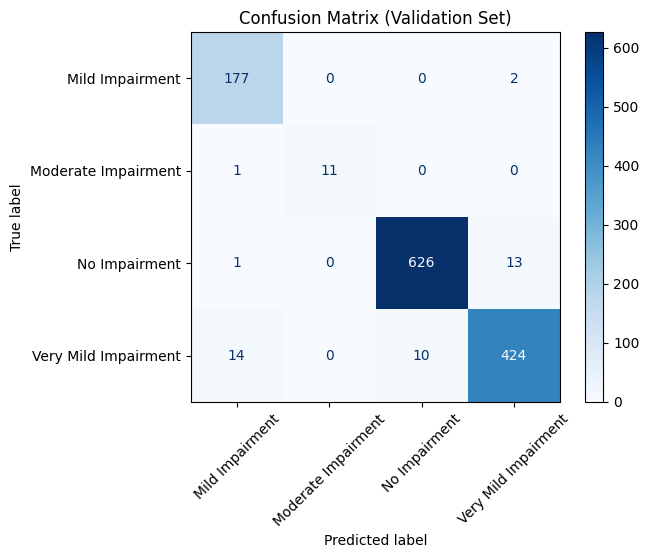

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

# y_true_val and y_pred_val are from the previous cell
# class_names should also be defined

plt.figure(figsize=(10, 8))
cm_display = ConfusionMatrixDisplay.from_predictions(
    y_true_val,
    y_pred_val,
    display_labels=class_names,
    cmap='Blues',
    xticks_rotation=45
)
plt.title('Confusion Matrix (Validation Set)')
plt.show()

# Plot ROC Curves and AUC

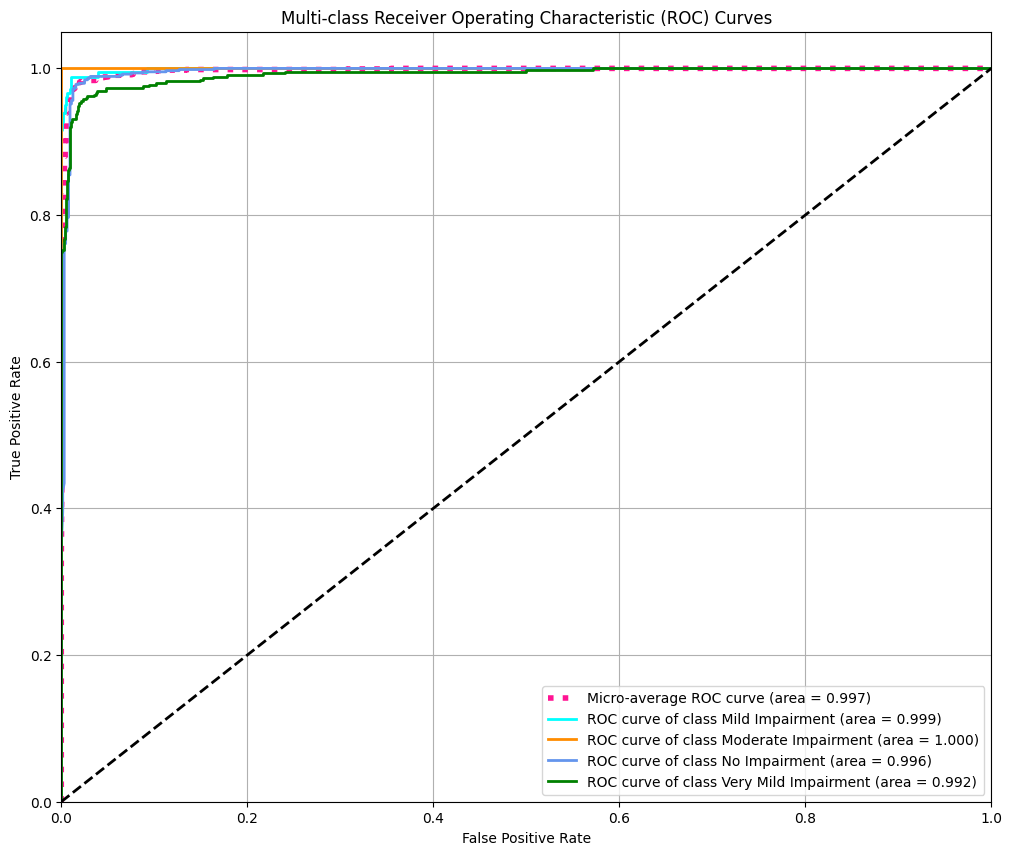

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# y_true_val and y_prob_val are from the evaluation in Cell 9
# Binarize the true labels
y_true_bin = label_binarize(y_true_val, classes=list(range(num_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob_val.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(12, 10))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.3f})',
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot Precision-Recall Curves

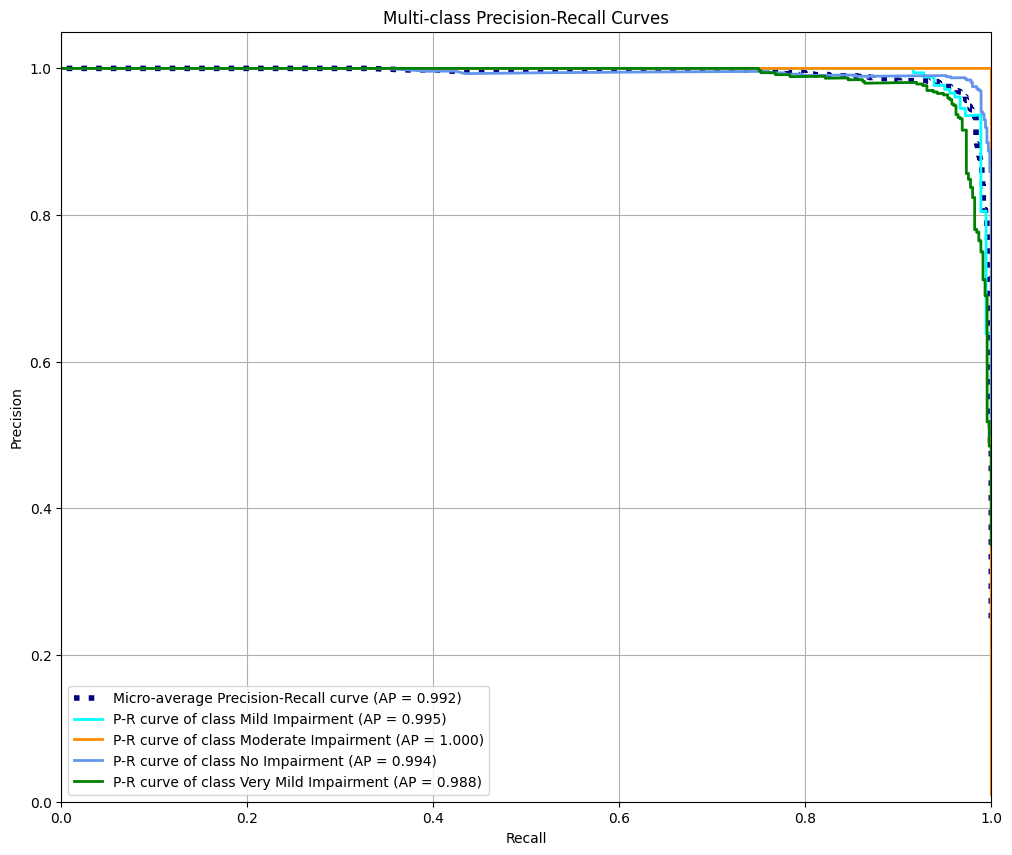

In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# y_true_bin and y_prob_val are from the previous cell or can be recalculated if needed.

precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_prob_val[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_prob_val[:, i])

# Compute micro-average Precision-Recall curve and AP
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), y_prob_val.ravel())
average_precision["micro"] = average_precision_score(y_true_bin.ravel(), y_prob_val.ravel(), average="micro")

plt.figure(figsize=(12, 10))
plt.plot(recall["micro"], precision["micro"],
         label=f'Micro-average Precision-Recall curve (AP = {average_precision["micro"]:0.3f})',
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(num_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'P-R curve of class {class_names[i]} (AP = {average_precision[i]:0.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-class Precision-Recall Curves')
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Explainable AI: Grad-CAM Visualization

✅ Grad-CAM initialized targeting layer: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


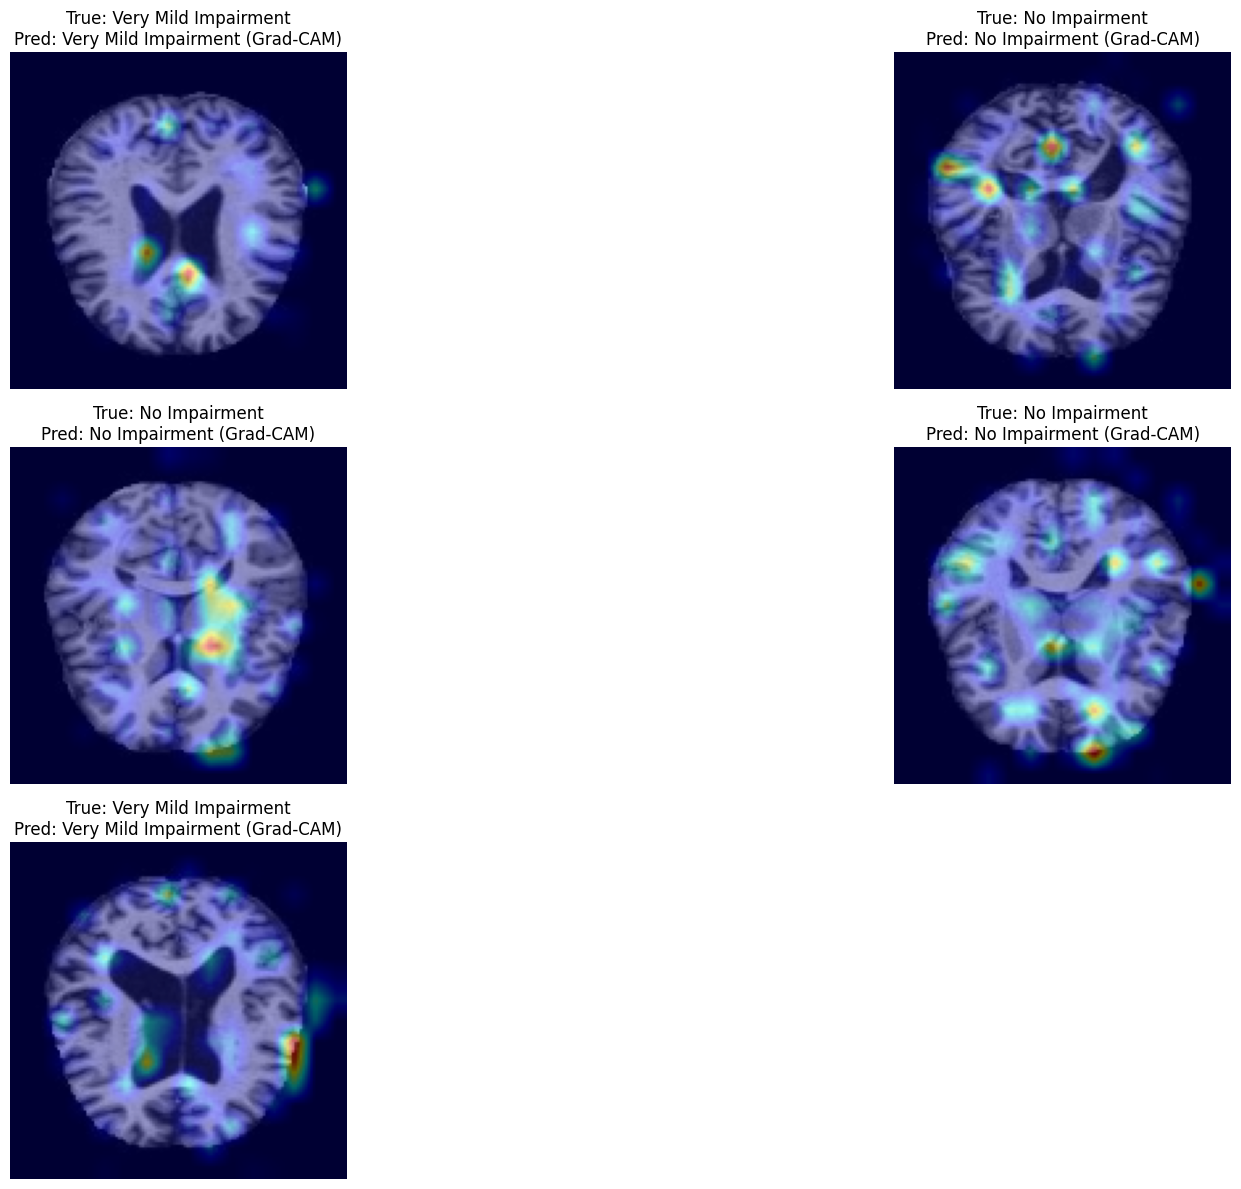

In [13]:
import cv2 # OpenCV for image manipulation

class GradCAM:
    def __init__(self, model_gc, target_layer_gc):
        self.model = model_gc
        self.target_layer = target_layer_gc
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]
            
        # Ensure target_layer is valid
        try:
            self.target_layer.register_forward_hook(forward_hook)
            self.target_layer.register_backward_hook(backward_hook)
        except AttributeError as e:
            print(f"Error registering hooks: {e}. Ensure target_layer is a valid nn.Module.")
            raise

    def generate_heatmap(self, input_tensor, class_idx=None):
        self.model.eval()
        self.model.zero_grad()
        
        output = self.model(input_tensor) # (1, num_classes)
        
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()
        
        # Target for backprop: score of the target class
        target_score = output[0, class_idx]
        target_score.backward()
        
        if self.gradients is None or self.activations is None:
            print("Error: Gradients or activations not captured. Check hook registration and backward pass.")
            return None, None

        # Pooled gradients (alpha_k)
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3]) # (num_channels)
        
        # Weight activations by pooled gradients
        activations_weighted = self.activations # (1, num_channels, H, W)
        for i in range(activations_weighted.shape[1]): # Loop over channels
            activations_weighted[:, i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activations_weighted, dim=1).squeeze() # (H, W)
        heatmap = F.relu(heatmap) # Apply ReLU
        
        # Normalize heatmap
        if heatmap.max() > 0:
            heatmap /= heatmap.max()
            
        return heatmap.cpu().detach().numpy(), class_idx

def superimpose_heatmap(heatmap, original_image_np, alpha=0.5, colormap=cv2.COLORMAP_JET):
    # Resize heatmap to match original image
    heatmap_resized = cv2.resize(heatmap, (original_image_np.shape[1], original_image_np.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) # Matplotlib uses RGB

    superimposed_img = (alpha * original_image_np * 255 + (1 - alpha) * heatmap_colored).astype(np.uint8)
    # If original_image_np is already uint8 [0,255], no need to multiply by 255
    # superimposed_img = cv2.addWeighted(cv2.cvtColor(np.uint8(original_image_np*255), cv2.COLOR_RGB2BGR), alpha, heatmap_colored, 1-alpha, 0)
    # superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    return superimposed_img

# --- Initialize Grad-CAM ---
# You need to choose a target layer. Often the last convolutional layer before GAP/Flatten.
# For AlzheimerCNN, model.features[-1] is MaxPool2d, model.features[-2] is ReLU, model.features[-3] is Conv2d.
# Let's target the output of the last Conv2d layer in the 'features' block.
# If model.features is nn.Sequential(conv1, relu1, pool1, conv2, relu2, pool2, ... convN, reluN, poolN)
# The Nth conv layer is at index -3 (if Nth layer is conv, relu, pool).
# In AlzheimerCNN, the last Conv2d is the 4th one. Its output is before the last ReLU and MaxPool.
# Let's target model.features[-3] (the last Conv2d layer)
# If the model structure changes, this target_layer might need adjustment.

try:
    # Example: targeting the last Conv2d layer of the 'features' sequential block
    # This depends on the exact structure of your AlzheimerCNN.
    # The last conv layer in the provided AlzheimerCNN is model.features[-3]
    # (sequence: ..., Conv2d, ReLU, MaxPool2d). We target the Conv2d.
    target_conv_layer = model.features[-3] # The last nn.Conv2d
    grad_cam = GradCAM(model, target_conv_layer)
    print(f"✅ Grad-CAM initialized targeting layer: {target_conv_layer}")
except Exception as e:
    print(f"Could not initialize GradCAM: {e}. The model structure might have changed or target layer is incorrect.")
    grad_cam = None


# --- Visualize Grad-CAM for a few samples ---
if grad_cam:
    num_gradcam_samples = 5
    # Get some samples from the validation set (X_val, y_val are NumPy arrays)
    # X_val shape: (num_samples, channels, height, width)
    # y_val shape: (num_samples,)
    
    # De-normalize for visualization
    inv_normalize = transforms.Normalize(
       mean=[-m/s for m, s in zip(mean, std)],
       std=[1/s for s in std]
    )

    plt.figure(figsize=(20, 5 * num_gradcam_samples // 2))
    for i in range(num_gradcam_samples):
        idx = np.random.randint(0, len(X_val))
        sample_image_np = X_val[idx] # (C, H, W)
        sample_label = y_val[idx]

        # Convert to tensor, add batch dimension, and move to device
        sample_tensor = torch.tensor(sample_image_np, dtype=torch.float32).unsqueeze(0).to(device)

        heatmap, predicted_class_idx = grad_cam.generate_heatmap(sample_tensor)
        
        if heatmap is None:
            print(f"Skipping Grad-CAM for sample {i} due to heatmap generation error.")
            continue

        # De-normalize the image for display
        # Create a dummy tensor for de-normalization transform
        display_img_tensor = torch.tensor(sample_image_np, dtype=torch.float32)
        display_img_tensor = inv_normalize(display_img_tensor)
        original_image_display = display_img_tensor.permute(1, 2, 0).cpu().numpy() # HWC for matplotlib
        original_image_display = np.clip(original_image_display, 0, 1) # Clip values to [0,1]

        superimposed_image = superimpose_heatmap(heatmap, original_image_display, alpha=0.6)

        plt.subplot(num_gradcam_samples // 2 + num_gradcam_samples % 2, 2, i + 1) # Adjust subplot layout
        plt.imshow(superimposed_image)
        plt.title(f"True: {class_names[sample_label]}\nPred: {class_names[predicted_class_idx]} (Grad-CAM)")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Grad-CAM was not initialized. Skipping visualization.")

# Predict and Visualize Random Samples

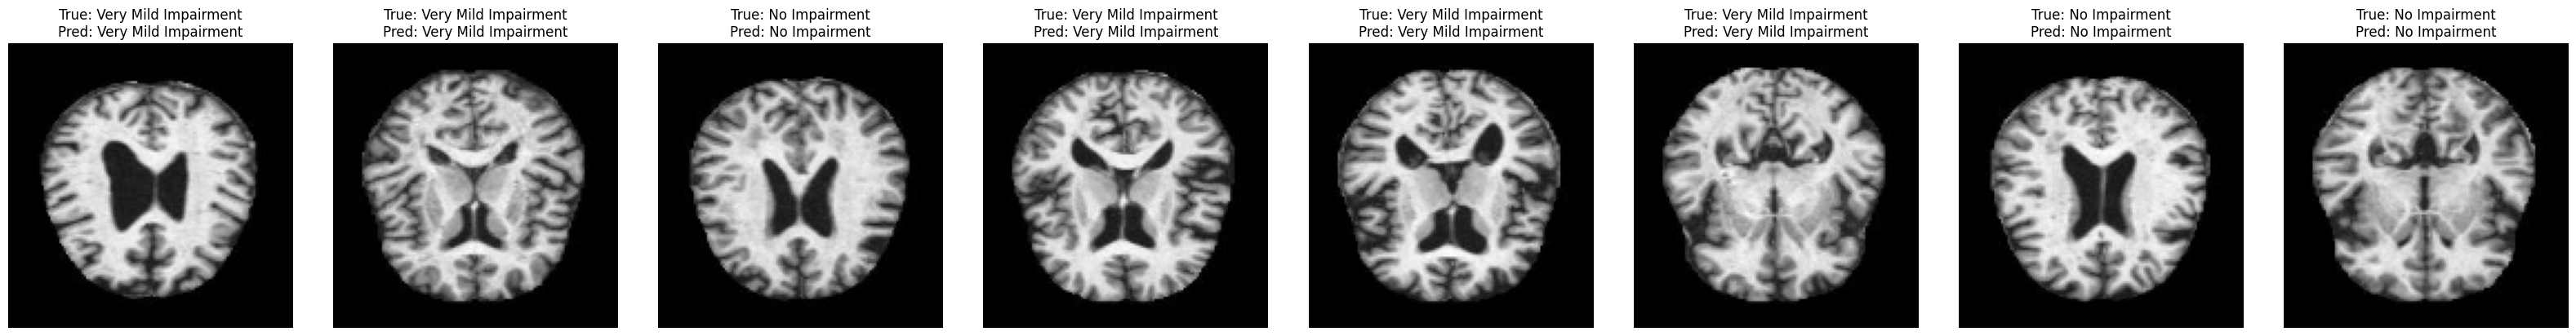

In [19]:
import random

def predict_random_val_samples(model_pred, X_data, y_data, class_names_pred, num_samples=5, device_pred='cpu'):
    model_pred.eval()
    
    if len(X_data) == 0:
        print("No data to sample from.")
        return

    num_to_sample = min(num_samples, len(X_data))
    indices = random.sample(range(len(X_data)), num_to_sample)
    
    # Inverse normalization transform for display
    inv_normalize_display = transforms.Normalize(
       mean=[-m/s for m, s in zip(mean, std)], # mean and std from Cell 2
       std=[1/s for s in std]
    )

    fig, axes = plt.subplots(1, num_to_sample, figsize=(num_to_sample * 4, 4))
    if num_to_sample == 1: # Ensure axes is iterable
        axes = [axes]

    for i, idx in enumerate(indices):
        sample_image_np = X_data[idx]  # (C, H, W)
        true_label_idx = y_data[idx]

        # Convert to tensor, add batch dim, move to device
        input_tensor = torch.tensor(sample_image_np, dtype=torch.float32).unsqueeze(0).to(device_pred)

        with torch.no_grad():
            outputs = model_pred(input_tensor)
            _, pred_label_idx = torch.max(outputs, 1)
            pred_label_idx = pred_label_idx.item()

        # De-normalize image for display
        display_img_tensor = torch.tensor(sample_image_np, dtype=torch.float32) # No need to move to device
        display_img_tensor = inv_normalize_display(display_img_tensor)
        img_display = display_img_tensor.permute(1, 2, 0).cpu().numpy() # HWC
        img_display = np.clip(img_display, 0, 1) # Clip to [0,1] for float images

        axes[i].imshow(img_display)
        axes[i].set_title(f"True: {class_names_pred[true_label_idx]}\nPred: {class_names_pred[pred_label_idx]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Use X_val, y_val (NumPy arrays) and class_names defined earlier
# Ensure model is on the correct device
predict_random_val_samples(model, X_val, y_val, class_names, num_samples=8, device_pred=device)